<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s9/s9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [2]:
# Manually unpgrading albumentations so the issue with ContextVersion not found when installing evalib is removed.
!pip uninstall albumentations -y
!pip uninstall imgaug -y
!pip install albumentations --upgrade

Failed to import the site module
Traceback (most recent call last):
  File "/usr/lib/python3.6/site.py", line 570, in <module>
  File "/usr/lib/python3.6/site.py", line 557, in main
    known_paths = addsitepackages(known_paths)
  File "/usr/lib/python3.6/site.py", line 345, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.6/site.py", line 213, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.6/site.py", line 174, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
KeyboardInterrupt
Uninstalling imgaug-0.2.6:
  Successfully uninstalled imgaug-0.2.6
Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.4.5)
Processing /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0/imgaug-0.2.6-cp36-none-any.whl


In [4]:
!pip install git+https://github.com/gantir/evalib.git@develop

  Cloning https://github.com/gantir/evalib.git (to revision develop) to /tmp/pip-req-build-92itxl5m
  Running command git clone -q https://github.com/gantir/evalib.git /tmp/pip-req-build-92itxl5m
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for evalib: filename=evalib-0.0.post0.dev31+g295c778-py2.py3-none-any.whl size=13921 sha256=8e376ff06e947e62eb2fe67f3521ca2acd9478b9db658e7b0283c94d99c08fba
  Stored in directory: /tmp/pip-ephem-wheel-cache-hffxxxzg/wheels/f6/38/b2/08942c9ce5bbe47f487156274e09033e4abe51a7acad6a6d66
Successfully built evalib


In [6]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
except:
  print('May be not using Google Colab')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from __future__ import print_function
import sys
from argparse import Namespace

import torch
import torchvision
from torchvision import  transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import numpy as np
from matplotlib.pyplot import imshow

In [0]:
import evalib
from evalib.gradcam.gradcam import GradCAM, GradCAMpp
from evalib.gradcam.utils import visualize_cam


In [0]:
def configure_optimizers(params, conf):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params, lr=conf.lr, momentum=0.9, weight_decay=conf.l2_decay)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
  return criterion, optimizer, scheduler

In [0]:
config = Namespace(
    batch_size = 64,
    batch_size_cuda = 64,
    num_workers = 4,
    SEED = 170,
    EPOCHS = 25,
    dropout = 0.0,
    lr = 1e-3,
    l1_decay =  0,
    l2_decay = 1e-4   
)
evalib.utils.init_seed(config.SEED)

In [12]:
data = evalib.data.cifar.CIFAR(config)

Extracting ./data/cifar-10-python.tar.gz to ./data


  car   cat  deer plane


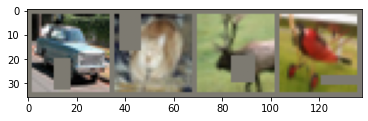

In [13]:
import numpy as np
from matplotlib import pyplot as plt

data_iter = iter(data.train_loader)
images, labels = data_iter.next()
index_start, index_end = 32,36
evalib.plot.imshow_torch(torchvision.utils.make_grid(images[index_start:index_end]))
print(' '.join('%5s' % data.classes[label] for label in labels[index_start:index_end]))

# imshow(transforms.ToPILImage()(images[32]))

In [15]:
net = evalib.models.resnet.ResNet18(config.dropout)
model = net.to(evalib.utils.get_device())
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
criterion, optimizer, scheduler = configure_optimizers(model.parameters(), config)

In [17]:
[(train_acc, train_loss), (val_acc, val_loss)] = evalib.tnt.train_n_test(model, criterion, optimizer, scheduler, data.train_loader, data.test_loader, num_epochs=config.EPOCHS)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


Batch Id/Size: 782/50000, Training Loss: 1.48750293, Training Accuracy: 44.8840%: 100%|██████████| 782/782 [00:58<00:00, 13.39it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01972901, Test Accuracy: 55.2600%

Epoch: 2


Batch Id/Size: 782/50000, Training Loss: 1.33455849, Training Accuracy: 60.9980%: 100%|██████████| 782/782 [00:58<00:00, 13.28it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01410067, Test Accuracy: 68.5100%

Epoch: 3


Batch Id/Size: 782/50000, Training Loss: 1.12363029, Training Accuracy: 68.2680%: 100%|██████████| 782/782 [00:59<00:00, 13.10it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01188006, Test Accuracy: 73.4300%

Epoch: 4


Batch Id/Size: 782/50000, Training Loss: 0.79519862, Training Accuracy: 72.6100%: 100%|██████████| 782/782 [01:00<00:00, 12.91it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01087954, Test Accuracy: 75.9400%

Epoch: 5


Batch Id/Size: 782/50000, Training Loss: 0.74907500, Training Accuracy: 75.9340%: 100%|██████████| 782/782 [01:00<00:00, 12.94it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00985155, Test Accuracy: 78.3300%

Epoch: 6


Batch Id/Size: 782/50000, Training Loss: 0.50731510, Training Accuracy: 78.1360%: 100%|██████████| 782/782 [01:00<00:00, 12.93it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00901872, Test Accuracy: 80.3900%

Epoch: 7


Batch Id/Size: 782/50000, Training Loss: 0.63364202, Training Accuracy: 79.9680%: 100%|██████████| 782/782 [01:00<00:00, 12.99it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00799866, Test Accuracy: 82.5300%

Epoch: 8


Batch Id/Size: 782/50000, Training Loss: 0.52303255, Training Accuracy: 81.6100%: 100%|██████████| 782/782 [01:00<00:00, 12.93it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00828509, Test Accuracy: 82.2300%

Epoch: 9


Batch Id/Size: 782/50000, Training Loss: 0.30386609, Training Accuracy: 82.7420%: 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00788448, Test Accuracy: 83.3300%

Epoch: 10


Batch Id/Size: 782/50000, Training Loss: 0.30224818, Training Accuracy: 83.9720%: 100%|██████████| 782/782 [01:00<00:00, 13.02it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00791269, Test Accuracy: 83.1100%

Epoch: 11


Batch Id/Size: 782/50000, Training Loss: 0.17066351, Training Accuracy: 87.1800%: 100%|██████████| 782/782 [01:00<00:00, 13.00it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.00025]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00676521, Test Accuracy: 85.5000%

Epoch: 12


Batch Id/Size: 782/50000, Training Loss: 0.42692637, Training Accuracy: 88.0700%: 100%|██████████| 782/782 [01:00<00:00, 13.01it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00670523, Test Accuracy: 85.7100%

Epoch: 13


Batch Id/Size: 782/50000, Training Loss: 0.05897774, Training Accuracy: 88.8720%: 100%|██████████| 782/782 [01:00<00:00, 12.98it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00663350, Test Accuracy: 85.8100%

Epoch: 14


Batch Id/Size: 782/50000, Training Loss: 0.06116366, Training Accuracy: 89.4560%: 100%|██████████| 782/782 [01:00<00:00, 13.01it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00664964, Test Accuracy: 86.0100%

Epoch: 15


Batch Id/Size: 782/50000, Training Loss: 0.24247126, Training Accuracy: 89.8800%: 100%|██████████| 782/782 [00:59<00:00, 13.05it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00683285, Test Accuracy: 85.6700%

Epoch: 16


Batch Id/Size: 782/50000, Training Loss: 0.09957060, Training Accuracy: 90.3120%: 100%|██████████| 782/782 [01:00<00:00, 13.01it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00692100, Test Accuracy: 85.6500%

Epoch: 17


Batch Id/Size: 782/50000, Training Loss: 0.28919324, Training Accuracy: 90.4700%: 100%|██████████| 782/782 [01:00<00:00, 12.95it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00706718, Test Accuracy: 85.4500%

Epoch: 18


Batch Id/Size: 782/50000, Training Loss: 0.12096936, Training Accuracy: 91.2220%: 100%|██████████| 782/782 [01:00<00:00, 12.94it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00690870, Test Accuracy: 85.8500%

Epoch: 19


Batch Id/Size: 782/50000, Training Loss: 0.16020596, Training Accuracy: 91.4280%: 100%|██████████| 782/782 [01:00<00:00, 12.99it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00703327, Test Accuracy: 85.9400%

Epoch: 20


Batch Id/Size: 782/50000, Training Loss: 0.40951064, Training Accuracy: 91.7080%: 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.0005]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00712283, Test Accuracy: 85.8300%

Epoch: 21


Batch Id/Size: 782/50000, Training Loss: 0.06741872, Training Accuracy: 93.1600%: 100%|██████████| 782/782 [00:59<00:00, 13.06it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.000125]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00632093, Test Accuracy: 87.1500%

Epoch: 22


Batch Id/Size: 782/50000, Training Loss: 0.09531674, Training Accuracy: 93.7440%: 100%|██████████| 782/782 [01:00<00:00, 13.00it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.00025]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00633895, Test Accuracy: 87.2800%

Epoch: 23


Batch Id/Size: 782/50000, Training Loss: 0.19380695, Training Accuracy: 94.1580%: 100%|██████████| 782/782 [00:59<00:00, 13.04it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.00025]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00646691, Test Accuracy: 87.3800%

Epoch: 24


Batch Id/Size: 782/50000, Training Loss: 0.03292900, Training Accuracy: 94.4500%: 100%|██████████| 782/782 [00:59<00:00, 13.04it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.00025]


  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00633275, Test Accuracy: 87.3500%

Epoch: 25


Batch Id/Size: 782/50000, Training Loss: 0.15512823, Training Accuracy: 94.5080%: 100%|██████████| 782/782 [01:00<00:00, 12.90it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.00025]


100%|██████████| 157/157 [00:03<00:00, 41.46it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00649456, Test Accuracy: 87.2000%



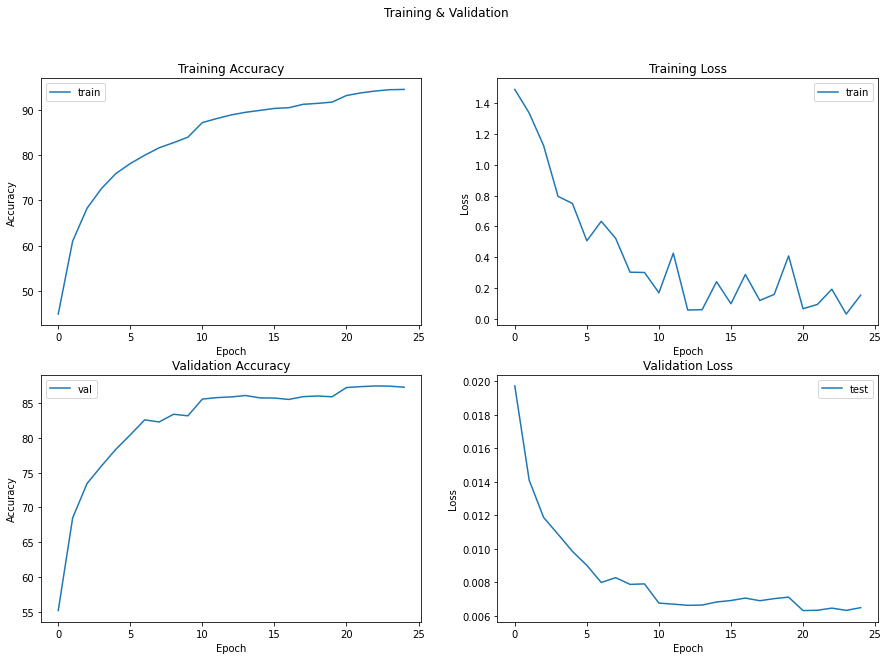

In [18]:
evalib.plot.plot_acc_loss(
    {'train': train_acc},
    {'val': val_acc},
    {'train': train_loss},
    {'test': val_loss}
)

In [0]:
c,w = evalib.tnt.get_correct_wrong_predictions(model, data.test_loader,count=25)

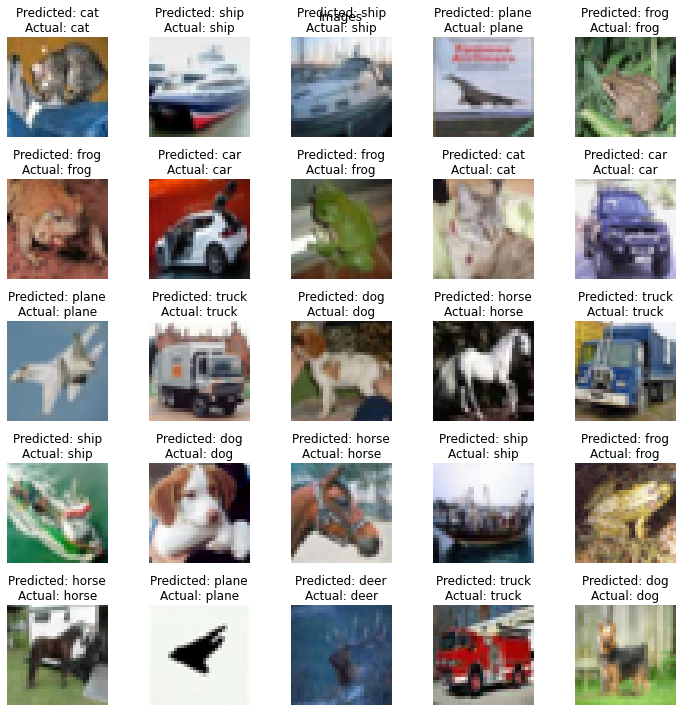

In [20]:
evalib.plot.plot_images(c, data.classes, "correct_imgs.png")


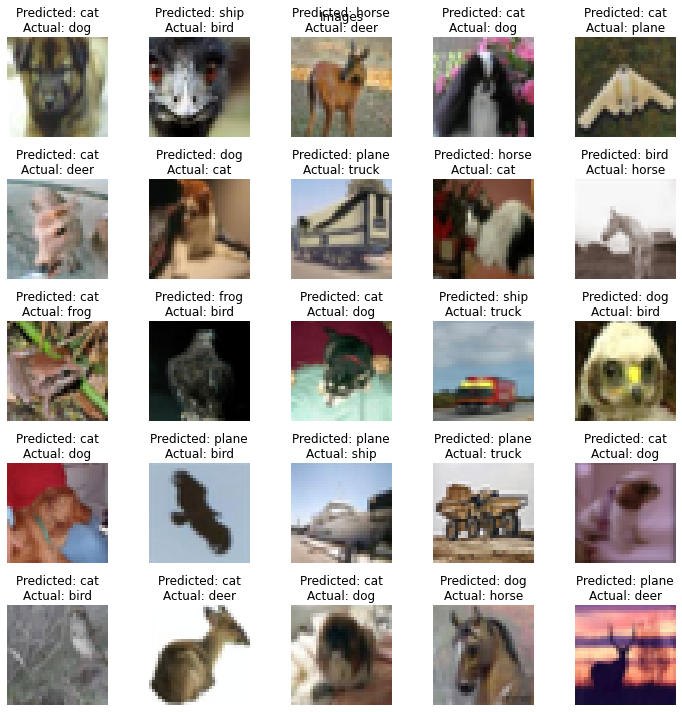

In [21]:
evalib.plot.plot_images(w, data.classes, "Wrong_imgs.png")


In [0]:
# Grad Cam
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer1'),
    dict(model_type='resnet', arch=model, layer_name='layer2'),
    dict(model_type='resnet', arch=model, layer_name='layer3'),
    dict(model_type='resnet', arch=model, layer_name='layer4'),
]

for config in configs:
    config['arch'].to(evalib.utils.get_device()).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [0]:
torch_images = [i['img'].to(evalib.utils.get_device()) for i in w]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


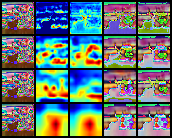

In [25]:
for torch_img in torch_images:
  images = []
  normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
  for gradcam, gradcam_pp in cams:
      mask, _ = gradcam(normed_torch_img)
      heatmap, result = visualize_cam(mask, torch_img)

      mask_pp, _ = gradcam_pp(normed_torch_img)
      heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
      
      images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
  grid_image = torchvision.utils.make_grid(images, nrow=5)

torchvision.transforms.ToPILImage()(grid_image)
